In [1]:
import pandas as pd
from osgeo import gdal
import numpy as np
import time, os

%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.patches as patches

font = { 'family' : 'monospace', 'weight' : 'bold', 'size' : 18}
plt.rc('font',**font)

In [2]:
datadirectory = 'E:\E-Downloads\wa_v2\cra'
datefile= 'S32631X402380Y1491460sS1_A_vv_0001_A_mtfil.dates'
imagefile= 'S32631X402380Y1491460sS1_A_vv_0001_A_mtfil.vrt'

In [3]:
os.chdir(datadirectory)

In [4]:
#Acquisition Dates

dates=open(datefile).readlines()
tindex=pd.DatetimeIndex(dates)
j=1
print('Bands and dates for', imagefile)
for i in tindex:
    print("{:4d} {}".format(j, i.date()), end='')
    j+=1
    if j%5==1: print()

Bands and dates for S32631X402380Y1491460sS1_A_vv_0001_A_mtfil.vrt
   1 2015-04-03   2 2015-11-17   3 2015-11-29   4 2015-12-11   5 2015-12-23
   6 2016-01-04   7 2016-01-28   8 2016-02-09   9 2016-03-04  10 2016-03-16
  11 2016-03-28  12 2016-04-09  13 2016-04-21  14 2016-05-03  15 2016-05-15
  16 2016-05-27  17 2016-06-08  18 2016-07-02  19 2016-07-14  20 2016-07-26
  21 2016-08-07  22 2016-08-19  23 2016-08-31  24 2016-09-12  25 2016-09-24
  26 2016-10-06  27 2016-10-18  28 2016-10-30  29 2016-11-11  30 2016-11-23
  31 2016-12-05  32 2016-12-17  33 2016-12-29  34 2017-01-10  35 2017-01-22
  36 2017-02-03  37 2017-02-15  38 2017-02-27  39 2017-03-11  40 2017-03-23
  41 2017-04-04  42 2017-04-16  43 2017-04-28  44 2017-05-10  45 2017-05-22
  46 2017-06-03  47 2017-06-15  48 2017-06-27  49 2017-07-09  50 2017-07-21
  51 2017-08-02  52 2017-08-14  53 2017-08-26  54 2017-09-07  55 2017-09-19
  56 2017-10-13  57 2017-10-25  58 2017-11-06  59 2017-11-18  60 2017-11-30


In [5]:
rasterstack=gdal.Open(imagefile).ReadAsArray()

In [9]:
#Data Pre-Processing

#Plot the global means of the Time Series

caldB=-83
calPwr = np.power(10.,caldB/10.)
rasterstack_pwr = np.power(rasterstack, 2.)*calPwr
rs_means_pwr = np.mean(rasterstack_pwr, axis=(1,2))
rs_means_dB = 10.*np.log10(rs_means_pwr)

In [10]:
ts = pd.Series(rs_means_dB, index=tindex)

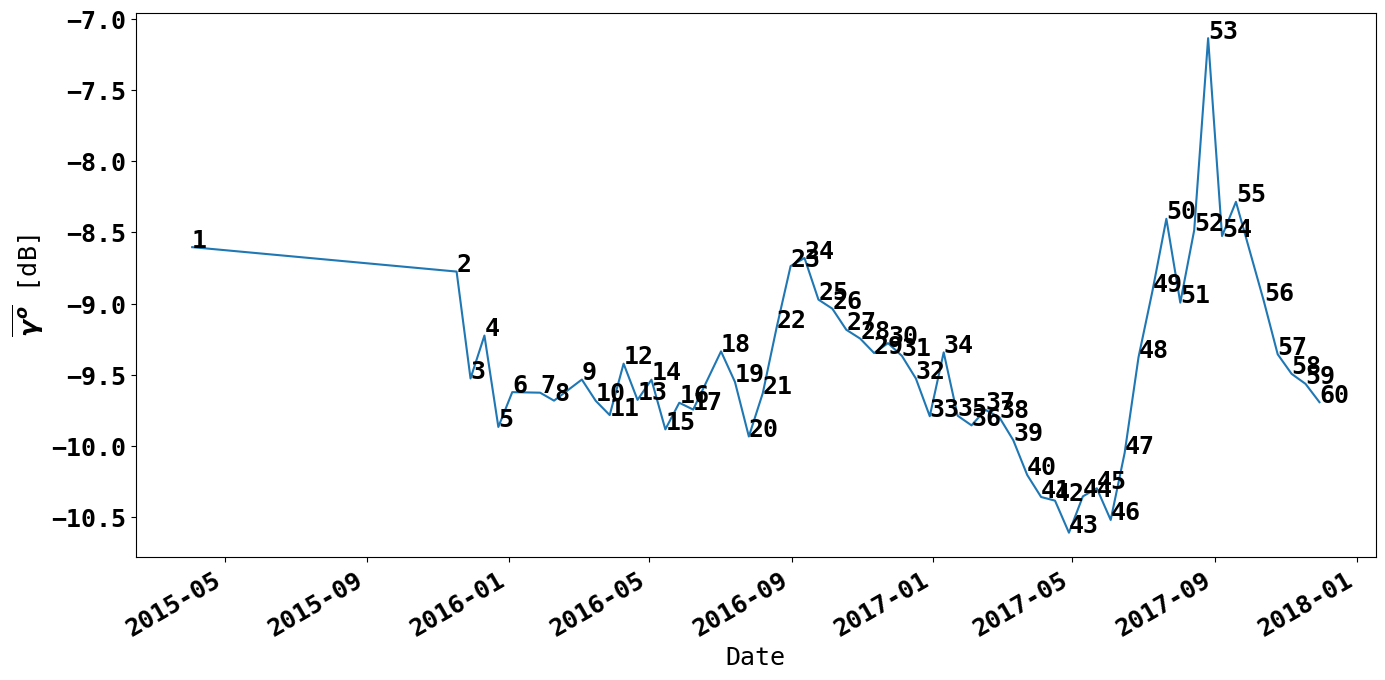

In [11]:
plt.figure(figsize=(16,8))
ts.plot()
xl = plt.xlabel("Date")
yl = plt.ylabel("$\overline{\gamma^o}$ [dB]")
for xyb in zip(ts.index, rs_means_dB, range(1, len(ts)+1)):
    plt.annotate(xyb[2], xy=xyb[0:2])

In [17]:
# Generate Time Series for Point Locations or Subsets
def showImage(rasterstack, tindex, bandnbr, subset=None, vmin=None, vmax=None):
    '''Input:
    rasterstack stack of images in SAR power unit
    tindex times series date index
    bandnbr bandnumber of the rasterstack to display'''
    fig=plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    if vmin==None: vmin=np.percentile(rasterstack[bandnbr-1].flatten(),5)
    if vmax==None: vmax=np.percentile(rasterstack[bandnbr-1].flatten(),95)

    ax1.imshow(rasterstack[bandnbr-1], cmap='gray', vmin=vmin, vmax=vmax)
    ax1.set_title("Image Band {}{}".format(bandnbr, tindex[bandnbr-1].date()))
    if subset==None:
        bands, ydim, xdim= rasterstack.shape
        subset=(0,0,xdim,ydim)

    ax1.add_patch(patches.Rectangle((subset[0], subset[1]), subset[2], subset[3], fill=False, edgecolor='red'))
    ax1.xaxis.set_label_text("Pixel")
    ax1.yaxis.set_label_text("Line")

    ts_pwr=np.mean(rasterstack[:,subset[1]:(subset[1]+subset[3]), subset[0]:(subset[0]+subset[2])], axis=(1,2))
    ts_dB=10.*np.log10(ts_pwr)
    ax2.plot(tindex, ts_dB)
    ax2.yaxis.set_label_text("$\gamma^o$ [dB]")
    ax2.set_title("$\gamma^o$ Backscatter Time Series")
    ax2.axvline(tindex[bandnbr-1], color='red')

    fig.autofmt_xdate()
    
        



In [13]:
bandnbr=24
subset=[5,20,3,3]

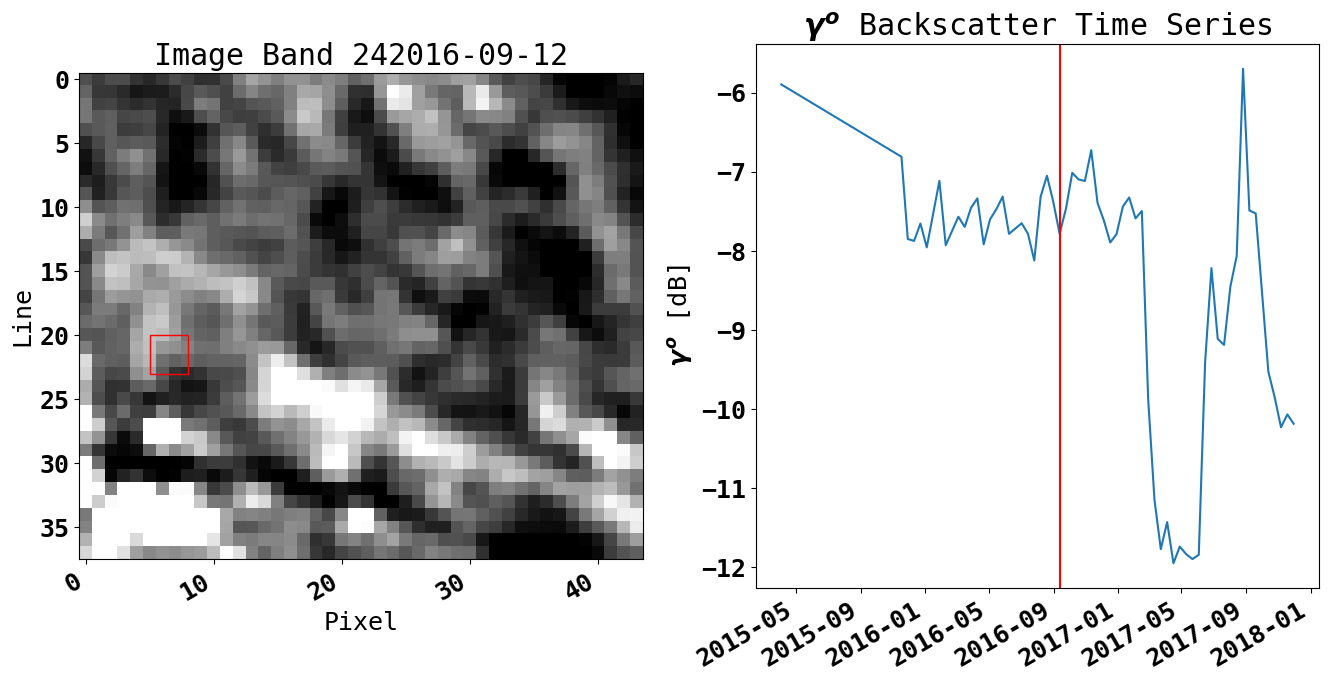

In [18]:
showImage(rasterstack_pwr, tindex, bandnbr, subset)

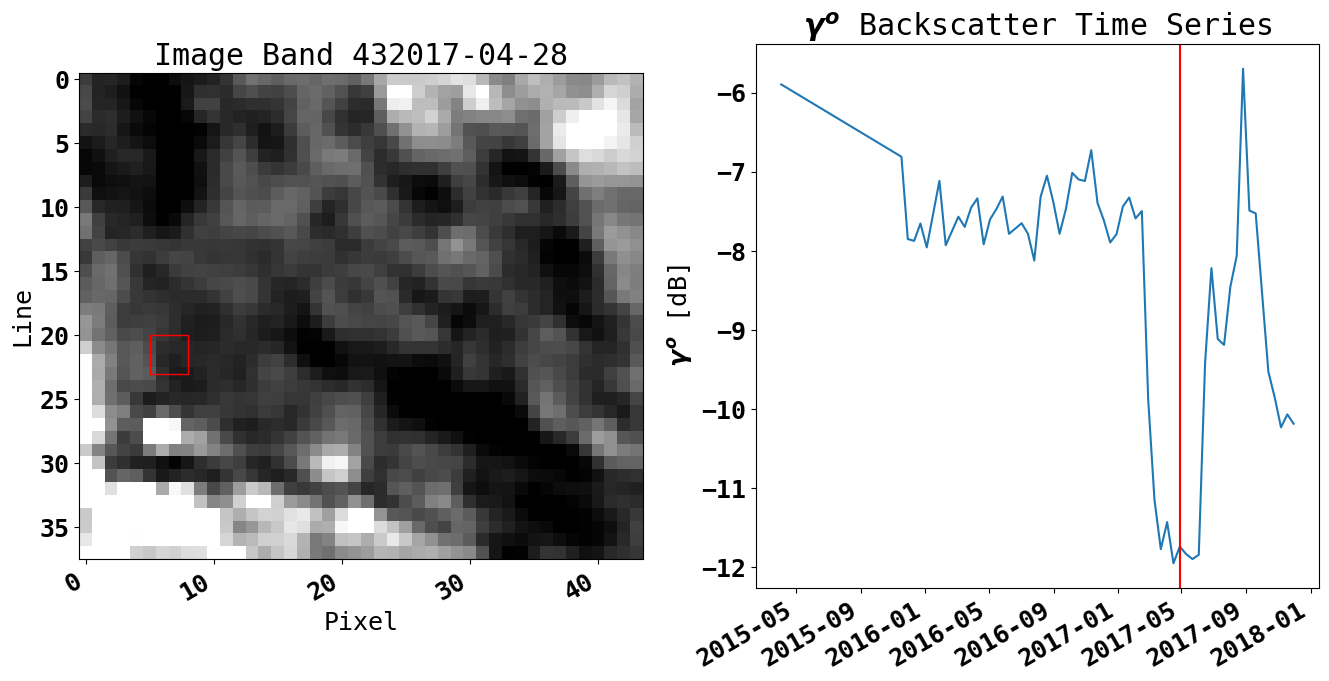

In [19]:
bandnbr=43
showImage(rasterstack_pwr, tindex, bandnbr, subset)

In [23]:
def timeSeries(rasterstack_pwr, tindex, subset, ndv=0.):
    raster=rasterstack_pwr.copy()
    if ndv != np.nan: raster[np.equal(raster,ndv)]=np.nan
    ts_pwr=np.nanmean(raster[:, subset[1]:(subset[1]+subset[3]), subset[0]:(subset[0]+subset[2])], axis=(1,2))
    ts_dB=10.*np.log10(ts_pwr)
    ts = pd.Series(ts_dB, index = tindex)
    return ts

In [24]:
ts = timeSeries(rasterstack_pwr, tindex, subset)

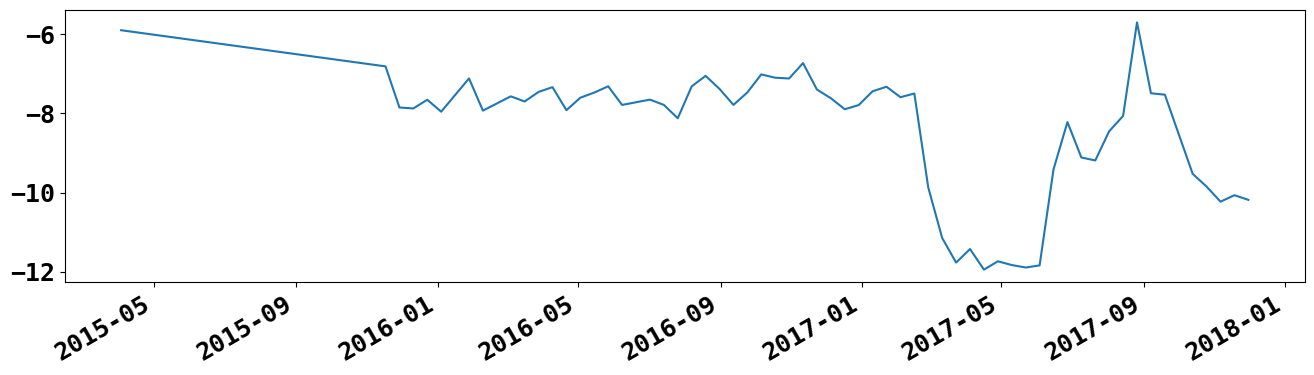

In [25]:
_=ts.plot(figsize=(16,4))

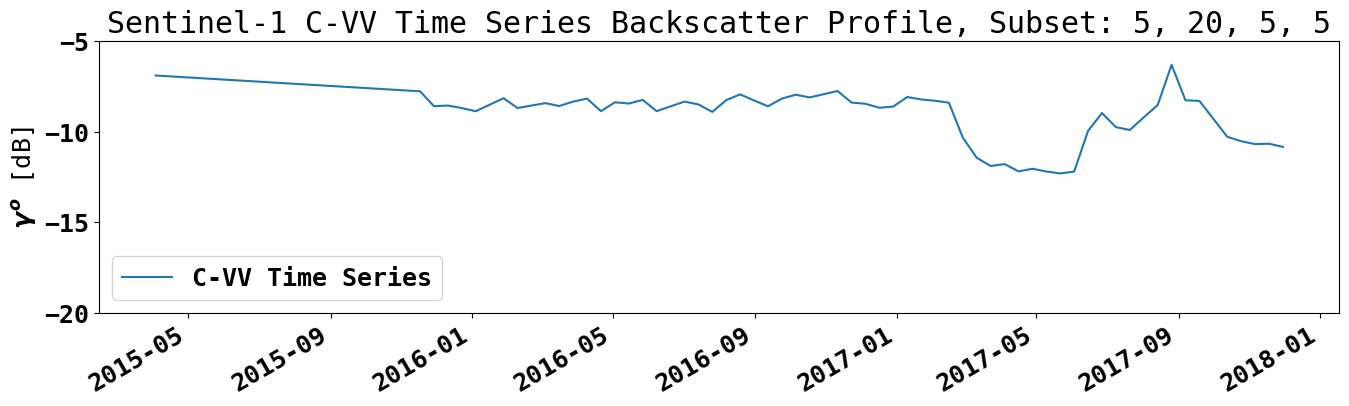

In [27]:
# Seasonal Subsets of time series records

subset=(5,20,5,5)
ts = timeSeries(rasterstack_pwr, tindex, subset)
tsdf = pd.DataFrame(ts, index=ts.index, columns=["g0"])

ylim=(-20, -5)
tsdf.plot(figsize=(16,4))
plt.title("Sentinel-1 C-VV Time Series Backscatter Profile, Subset: 5, 20, 5, 5")
plt.ylabel("$\gamma^o$ [dB]")
plt.ylim(ylim)
_=plt.legend(["C-VV Time Series"])


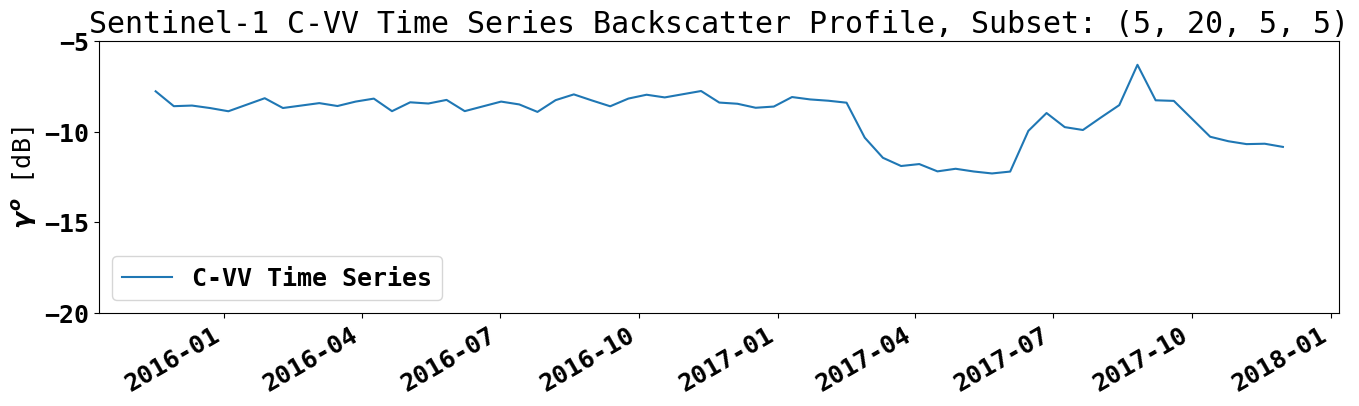

In [28]:
# Start the time series in November 2015

tsdf_sub1=tsdf[tsdf.index>"2015-11-01"]

tsdf_sub1.plot(figsize=(16,4))
plt.title("Sentinel-1 C-VV Time Series Backscatter Profile, Subset: {}".format(subset))
plt.ylabel("$\gamma^o$ [dB]")
plt.ylim(ylim)
_=plt.legend(["C-VV Time Series"])

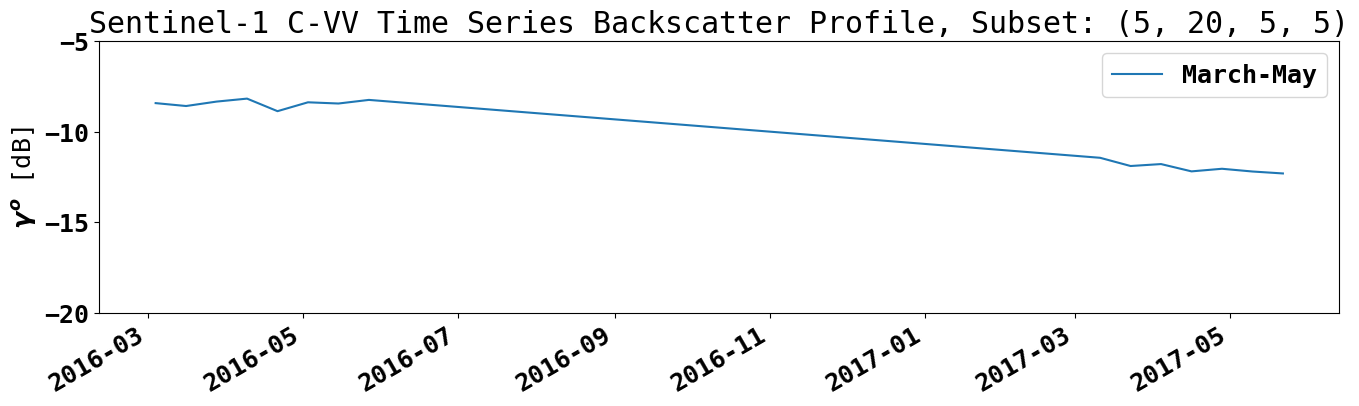

In [29]:
# March to May data only

tsdf_sub2=tsdf_sub1[np.logical_and(tsdf_sub1.index.month>=3, tsdf_sub1.index.month<=5)]

#Plot
fig, ax = plt.subplots(figsize=(16,4))
tsdf_sub2.plot(ax=ax)
plt.title("Sentinel-1 C-VV Time Series Backscatter Profile, Subset: {}".format(subset))
plt.ylabel("$\gamma^o$ [dB]")
plt.ylim(ylim)
_=plt.legend(["March-May"])
           

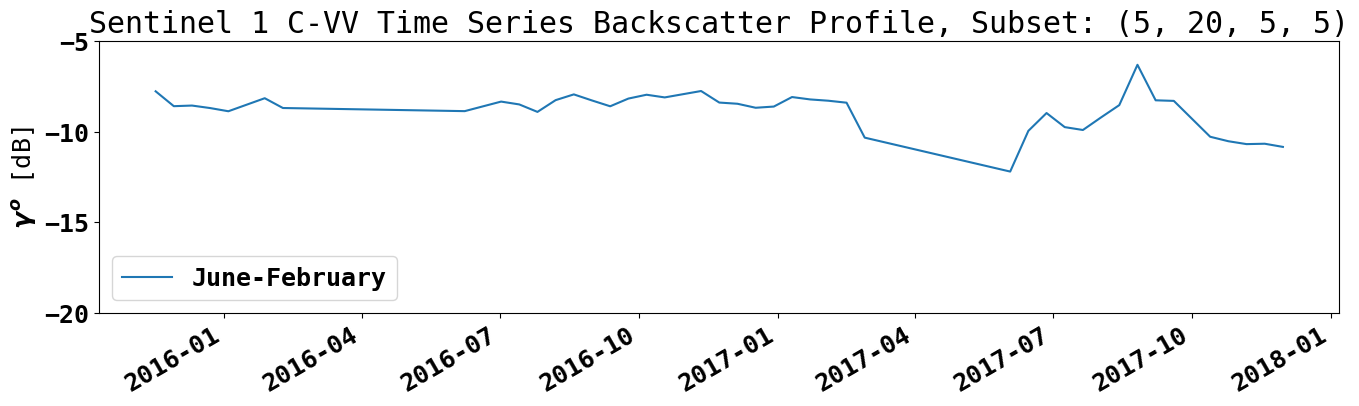

In [30]:
tsdf_sub3=tsdf_sub1[np.invert(np.logical_and(tsdf_sub1.index.month>=3, tsdf_sub1.index.month<=5))]

fig,ax=plt.subplots(figsize=(16,4))
tsdf_sub3.plot(ax=ax)
plt.title("Sentinel 1 C-VV Time Series Backscatter Profile, Subset: {}".format(subset))
plt.ylabel("$\gamma^o$ [dB]")
plt.ylim(ylim)
_=plt.legend(["June-February"])

In [32]:
#Group time series by year to compare average backscatter values

ts_sub_by_year = tsdf_sub1.groupby(pd.Grouper(freq="Y"))

(-20.0, -5.0)

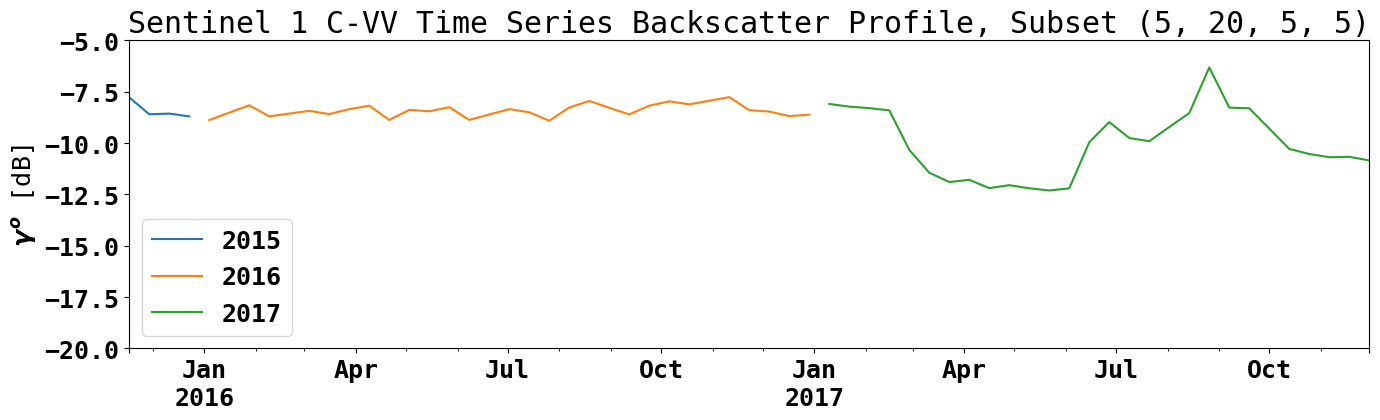

In [33]:
fig, ax = plt.subplots(figsize=(16,4))
for label, df in ts_sub_by_year:
    df.g0.plot(ax=ax, label=label.year)
plt.legend()
plt.title("Sentinel 1 C-VV Time Series Backscatter Profile, Subset {}".format(subset))
plt.ylabel("$\gamma^o$ [dB]")
plt.ylim(ylim)

In [34]:
#Make a pivot table to group year and sort by day of year for plotting overlapping series
tsdf_sub1 = tsdf_sub1.assign(doy = tsdf_sub1.index.dayofyear)
tsdf_sub1 = tsdf_sub1.assign(year = tsdf_sub1.index.year)

In [35]:
piv = pd.pivot_table(tsdf_sub1, index=['doy'], columns=['year'], values=['g0'])
piv.columns.set_names(['g0', 'Year'], inplace = True)
print(piv.head(10))
print("...\n", piv.tail(10))

g0     g0                     
Year 2015      2016       2017
doy                           
4     NaN -8.874602        NaN
10    NaN       NaN  -8.091206
22    NaN       NaN  -8.222770
28    NaN -8.155600        NaN
34    NaN       NaN  -8.294136
40    NaN -8.695752        NaN
46    NaN       NaN  -8.402759
58    NaN       NaN -10.330054
64    NaN -8.426312        NaN
70    NaN       NaN -11.441220
...
 g0          g0                     
Year      2015      2016       2017
doy                                
321  -7.774510       NaN        NaN
322        NaN       NaN -10.665520
328        NaN -8.395135        NaN
333  -8.594952       NaN        NaN
334        NaN       NaN -10.840596
340        NaN -8.461259        NaN
345  -8.560352       NaN        NaN
352        NaN -8.681982        NaN
357  -8.698992       NaN        NaN
364        NaN -8.615916        NaN


In [36]:
piv.columns.set_names(['g0', 'year'], inplace=True)

In [39]:
year_doy = ['2100-{}'.format(x) for x in piv.index]
y100_doy = pd.DatetimeIndex(pd.to_datetime(year_doy, format="%Y-%j"))

piv2=piv.copy()
piv2=piv2.assign(d100=y100_doy)
piv2=piv2.assign(doy=piv2.index)
piv2.set_index('d100', inplace=True, drop=True)
piv2 = piv2.interpolate(method='time')
piv2.set_index('doy', inplace=True, drop=True)

In [40]:
print(piv2.head(10))
print('...\n', piv2.tail(10))

g0     g0                     
year 2015      2016       2017
doy                           
4     NaN -8.874602        NaN
10    NaN -8.694852  -8.091206
22    NaN -8.335351  -8.222770
28    NaN -8.155600  -8.258453
34    NaN -8.425676  -8.294136
40    NaN -8.695752  -8.348448
46    NaN -8.628392  -8.402759
58    NaN -8.493672 -10.330054
64    NaN -8.426312 -10.885637
70    NaN -8.506059 -11.441220
...
 g0          g0                     
year      2015      2016       2017
doy                                
321  -7.774510 -8.023862 -10.667306
322  -7.842880 -8.076901 -10.665520
328  -8.253101 -8.395135 -10.753058
333  -8.594952 -8.422687 -10.826007
334  -8.592069 -8.428197 -10.840596
340  -8.574769 -8.461259 -10.840596
345  -8.560352 -8.553227 -10.840596
352  -8.641225 -8.681982 -10.840596
357  -8.698992 -8.654455 -10.840596
364  -8.698992 -8.615916 -10.840596


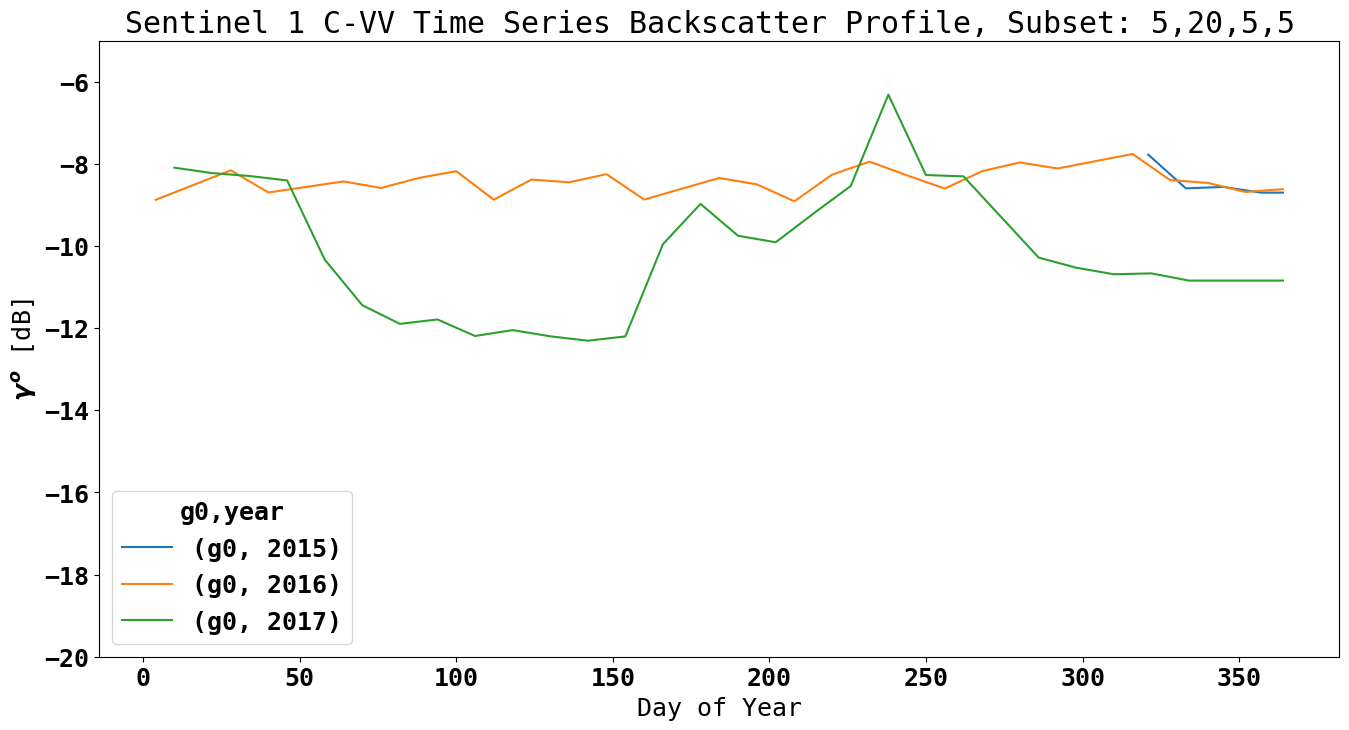

In [41]:
#Plotting overlapping years

piv2.plot(figsize=(16,8))
plt.title("Sentinel 1 C-VV Time Series Backscatter Profile, Subset: 5,20,5,5 ")
plt.ylabel("$\gamma^o$ [dB]")
plt.xlabel("Day of Year")
_=plt.ylim(ylim)
          

In [42]:
#Change detection on the Time Series Data

thres = 3 #Setting a dB Change threshold


In [46]:
diff1716 = (piv2.g0[2017]-piv2.g0[2016])

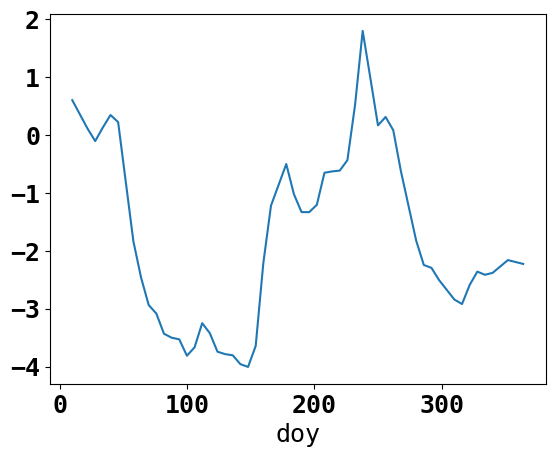

In [47]:
_=diff1716.plot(kind='line')

In [48]:
thres_exceeded = diff1716[abs(diff1716) > thres]
thres_exceeded

doy
76    -3.081974
82    -3.430615
88    -3.499177
94    -3.527523
100   -3.810760
106   -3.665967
112   -3.248034
118   -3.420952
124   -3.741039
130   -3.782975
136   -3.803250
142   -3.956439
148   -4.003891
154   -3.642117
dtype: float64

In [49]:
# Cumulative Sums for Change Detection

subset=(5,20,3,3)
ts1 = timeSeries(rasterstack_pwr, tindex, subset)
X = ts1[ts1.index>'2015-10-31']

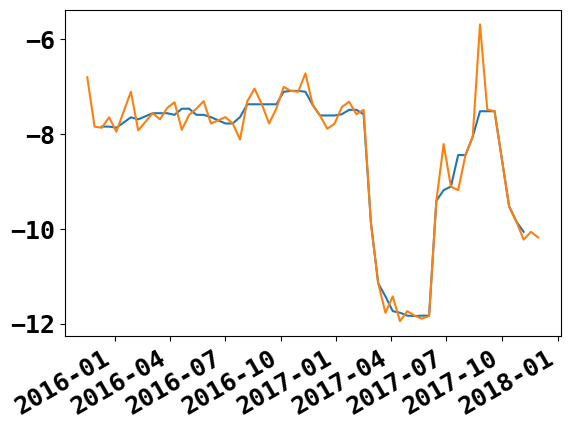

In [50]:
#Filtering the time series for outliers
Xr=X.rolling(5, center=True).median()
Xr.plot()
_=X.plot()

In [51]:
#Plottin Time Series and the mean over time span

X=Xr
Xmean = X.mean()

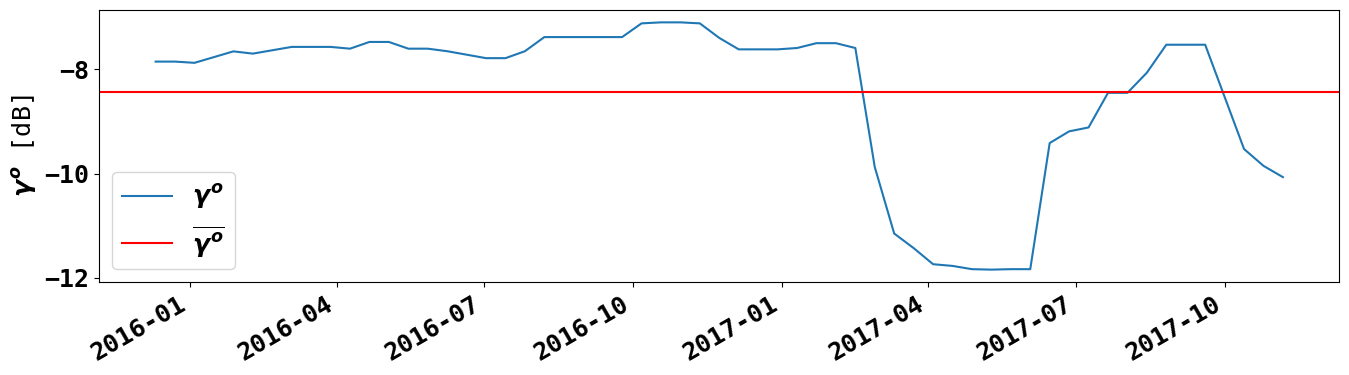

In [52]:
fig, ax = plt.subplots(figsize=(16,4))
X.plot()
plt.ylabel("$\gamma^o$ [dB]")
ax.axhline(Xmean, color='red')
_=plt.legend(['$\gamma^o$', '$\overline{\gamma^o}$'])

In [53]:
# To determine the residuals of the time series against the mean

R = X - Xmean

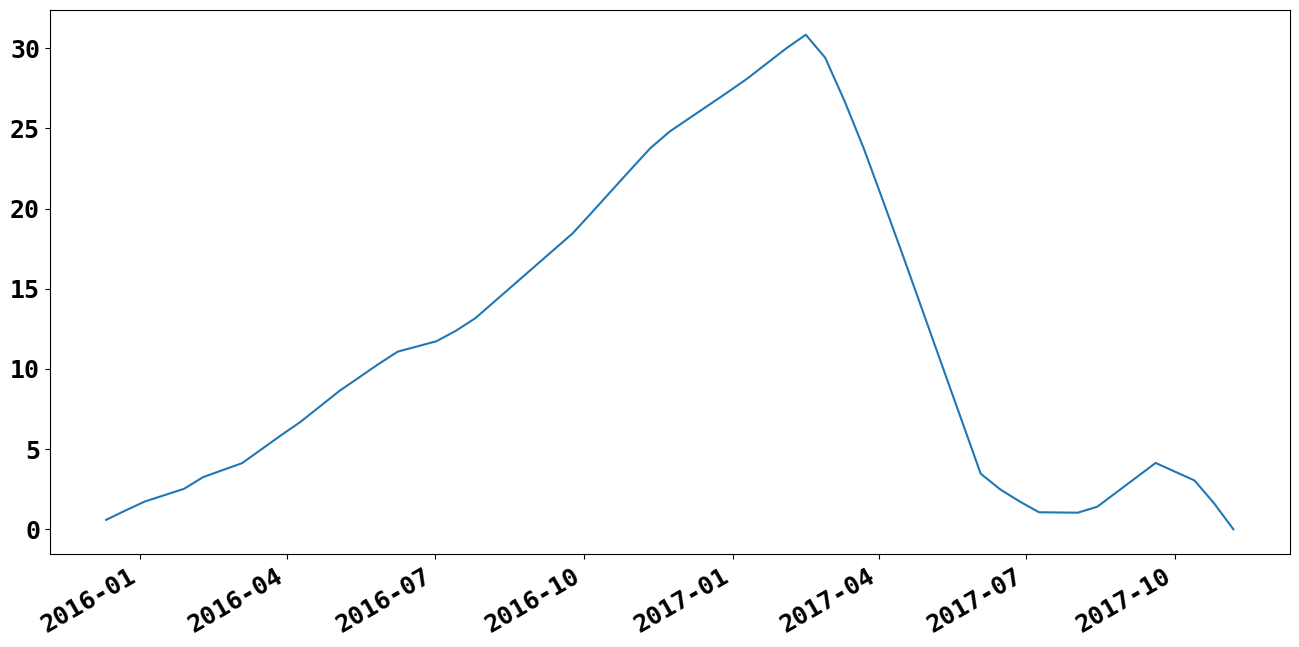

In [54]:
S = R.cumsum()

_=S.plot(figsize=(16,8))

In [55]:
# Magnitude of change is given as the difference between maximum nad minimum of S

Sdiff = S.max() - S.min()
Sdiff

30.847062820803636

In [56]:
#Time where Smax is found
t_cp_before = S[S==S.max()].index[0]
print("Last date before change: {}".format(t_cp_before.date()))

Last date before change: 2017-02-15


In [57]:
t_cp_after = S[S.index> t_cp_before].index[0]
print("First date after change: {}".format(t_cp_after.date()))

First date after change: 2017-02-27


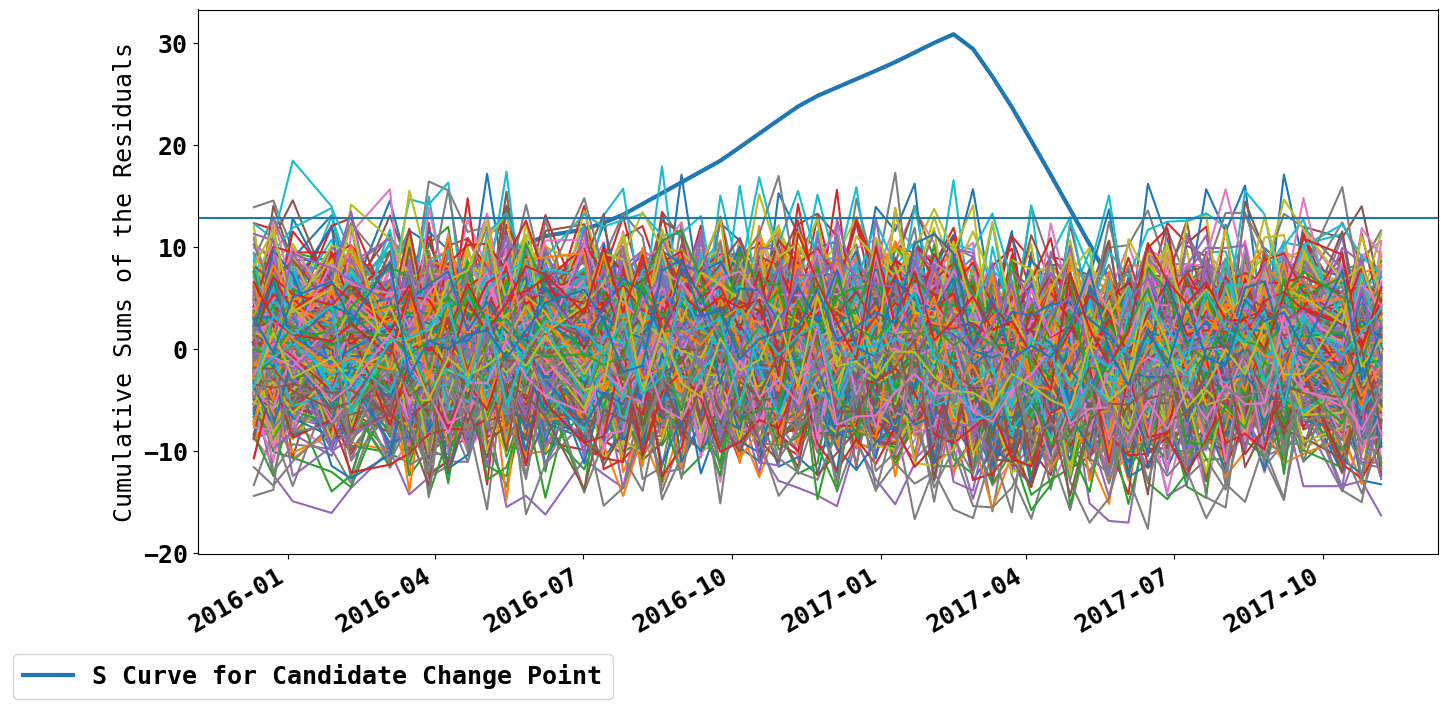

In [61]:
# Randomly reordering the time series to bootstrap the Cumulative Sums

n_bootstraps = 500
fig,ax = plt.subplots(figsize=(16,8))
S.plot(ax=ax, linewidth=3)
ax.set_ylabel("Cumulative Sums of the Residuals")
fig.legend(["S Curve for Candidate Change Point"], loc=3)
Sdiff_random_sum = 0
Sdiff_random_max=0

n_Sdiff_gt_Sdiff_random=0

for i in range(n_bootstraps):
    Rrandom = R.sample(frac=1)
    Srandom = Rrandom.cumsum()
    Sdiff_random = Srandom.max()-Srandom.min()
    Sdiff_random_sum +=Sdiff_random
    if Sdiff_random > Sdiff_random_max:
        Sdiff_random_max = Sdiff_random
    if Sdiff > Sdiff_random:
        n_Sdiff_gt_Sdiff_random +=1
    Srandom.plot(ax=ax)
_=ax.axhline(Sdiff_random_sum/n_bootstraps)

In [62]:
CL = 1.*n_Sdiff_gt_Sdiff_random/n_bootstraps
print("Confidence Level for Change Point {} percent".format(CL*100.))

Confidence Level for Change Point 100.0 percent


In [63]:
CP_significance = 1. - (Sdiff_random_sum/n_bootstraps)/Sdiff
print("Change Point significance metric : {}".format(CP_significance))

Change Point significance metric : 0.5832872448852253


In [65]:
S_ni=(S.abs()/S.abs().max()).cumsum().max()/len(S[S != np.nan])
print("Normalised Integral of Cumulative Sum : {}".format(S_ni))

Normalised Integral of Cumulative Sum : 0.3741739515908082


In [67]:
# A Global Image Means Time Series

means_pwr = np.mean(rasterstack_pwr, axis=(1,2))
means_dB = 10.*np.log10(means_pwr)
gm_ts = pd.Series(means_dB, index=tindex)
gm_ts=gm_ts[gm_ts.index> "2015-10-31"]
gm_ts=gm_ts.rolling(5, center=True).median()

<Axes: >

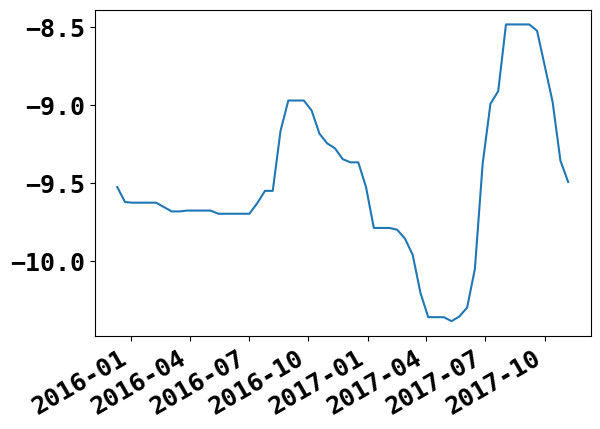

In [68]:
gm_ts.plot()

<Axes: >

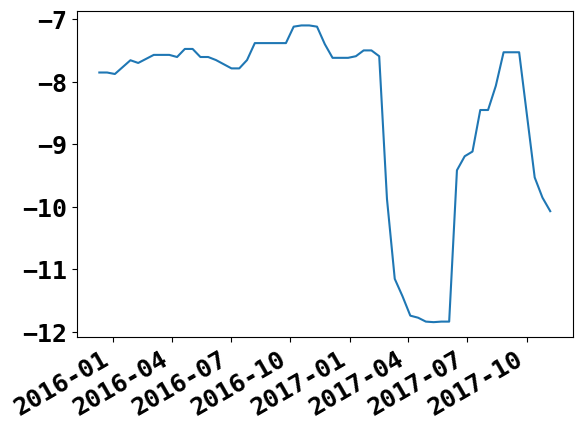

In [69]:
X.plot()

<Axes: >

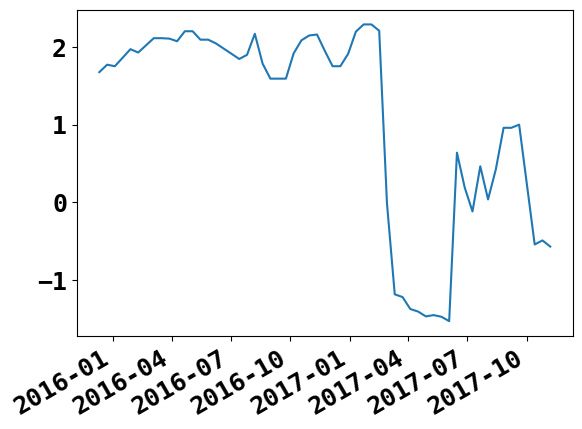

In [70]:
Xd = X-gm_ts
Xmean=Xd.mean()
Xd.plot()

In [71]:
R = Xd - Xmean

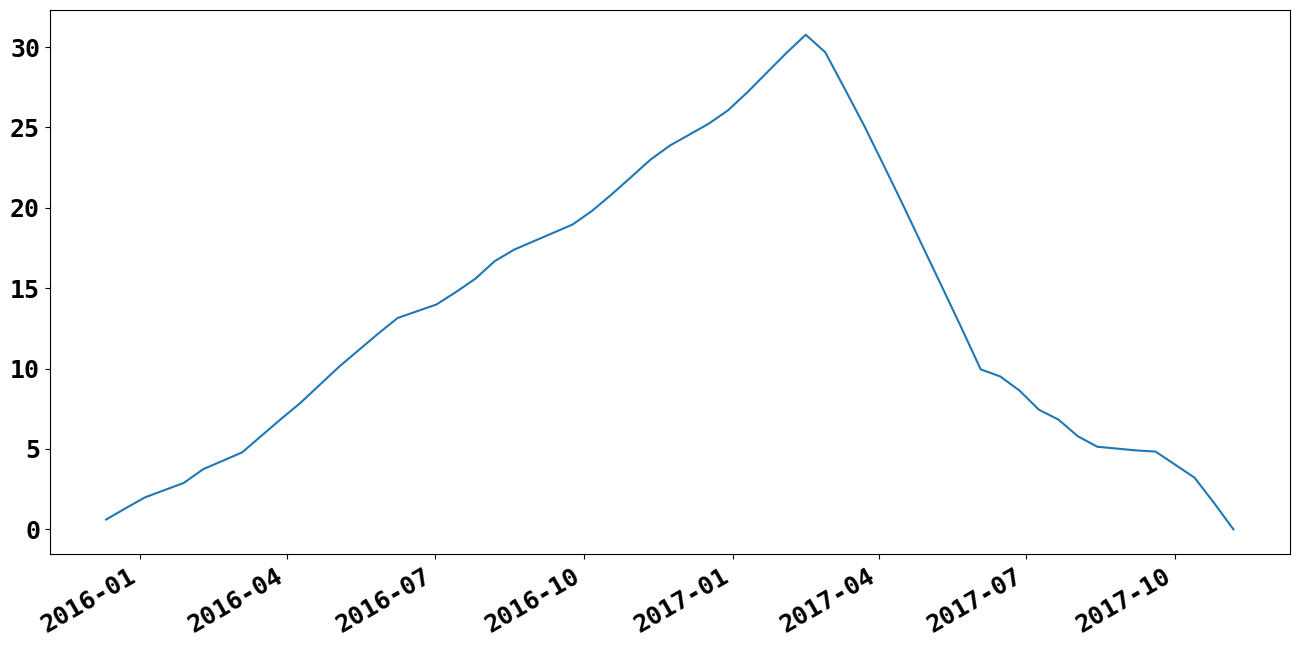

In [72]:
S = R.cumsum()
_=S.plot(figsize=(16,8))

In [73]:
Sdiff = S.max() - S.min()
Sdiff

30.765903052062473

In [74]:
t_cp_before = S[S==S.max()].index[0]
print("Last Date before change: {}".format(t_cp_before.date()))

Last Date before change: 2017-02-15


In [75]:
t_cp_after = S[S.index>t_cp_before].index[0]
print("First date after change: {}".format(t_cp_after.date()))

First date after change: 2017-02-27


In [77]:
# Cumulative Sum Change Detection for the entire image

X = rasterstack_pwr
X_sub=X[1:,:,:]
tindex_sub=tindex[1:]
X=10.*np.log10(X_sub)

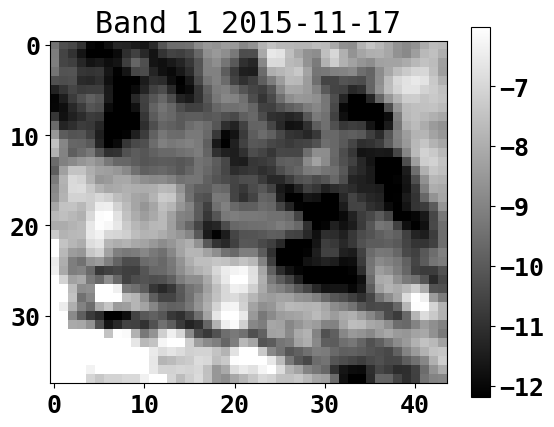

In [78]:
plt.figure()
bandnbr=0
vmin=np.percentile(X[bandnbr],5)
vmax=np.percentile(X[bandnbr],95)
plt.title("Band {} {}".format(bandnbr+1, tindex_sub[bandnbr].date()))
plt.imshow(X[0], cmap="gray", vmin=vmin, vmax=vmax)
_=plt.colorbar()

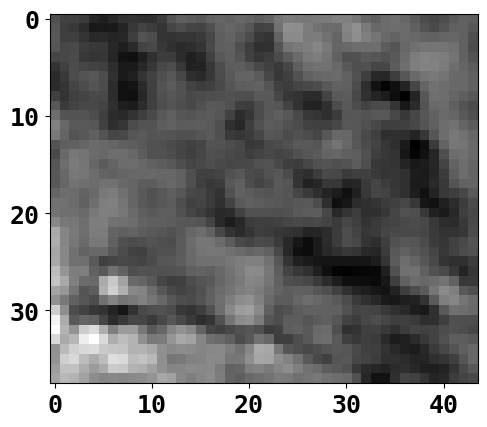

In [79]:
Xmean=np.mean(X,axis=0)
plt.figure()
plt.imshow(Xmean, cmap='gray')

In [80]:
X.shape

(59, 38, 44)

In [81]:
R = X-Xmean

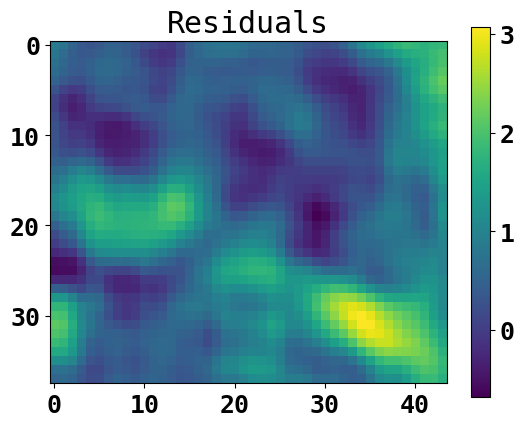

In [82]:
plt.imshow(R[0])
plt.title("Residuals")
_=plt.colorbar()

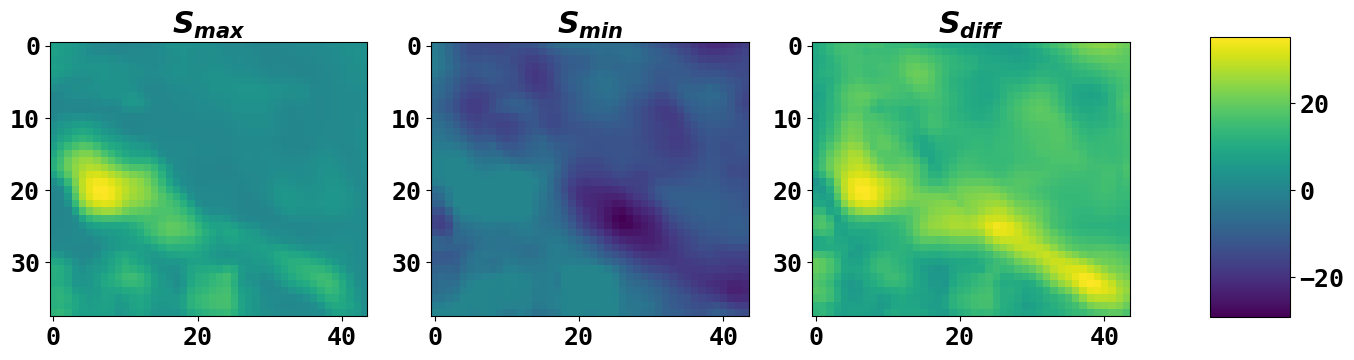

In [85]:
S = np.cumsum(R, axis=0)
Smax= np.max(S,axis=0)
Smin = np.min(S, axis=0)
Sdiff=Smax-Smin
fig,ax=plt.subplots(1,3,figsize=(16,4))
vmin=Smin.min()
vmax=Smax.max()
p=ax[0].imshow(Smax, vmin=vmin, vmax=vmax)
ax[0].set_title("$S_{max}$")
ax[1].imshow(Smin, vmin=vmin, vmax=vmax)
ax[1].set_title("$S_{min}$")
ax[2].imshow(Sdiff, vmin=vmin, vmax=vmax)
ax[2].set_title("$S_{diff}$")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
_=fig.colorbar(p,cax=cbar_ax)

At the 50% percentile, the threshold value is 19.82


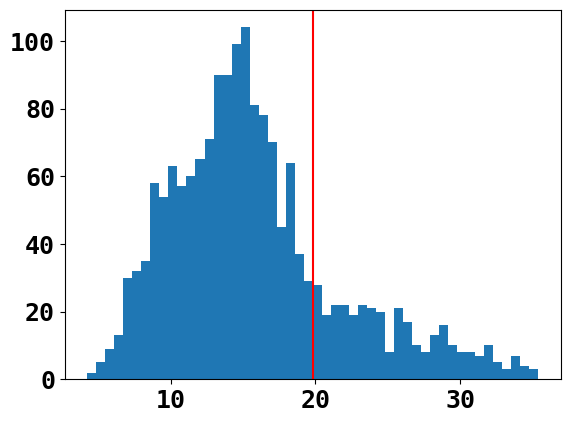

In [87]:
# Sdiff histogram

precentile = 50
fig,ax=plt.subplots()
h=ax.hist(Sdiff.flatten(),bins=50)
thres=np.percentile(h[1], 50)
print("At the {}% percentile, the threshold value is {:2.2f}".format(precentile, thres))
_=ax.axvline(thres, color='red')

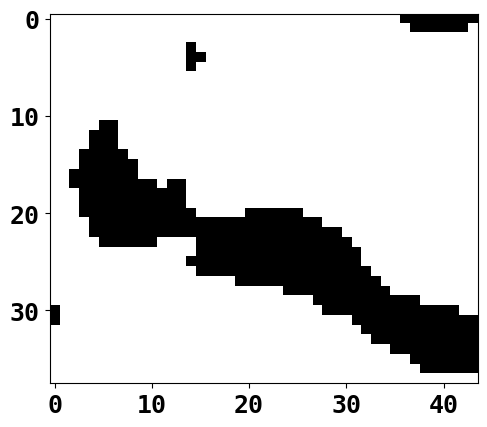

In [89]:
Sdiffmask = Sdiff<thres
_=plt.imshow(Sdiffmask, cmap='gray')

In [90]:
Rmask = np.broadcast_to(Sdiffmask, R.shape)

In [91]:
Rmasked = np.ma.array(R, mask=Rmask)

In [92]:
Smasked = np.ma.cumsum(Rmasked, axis=0)

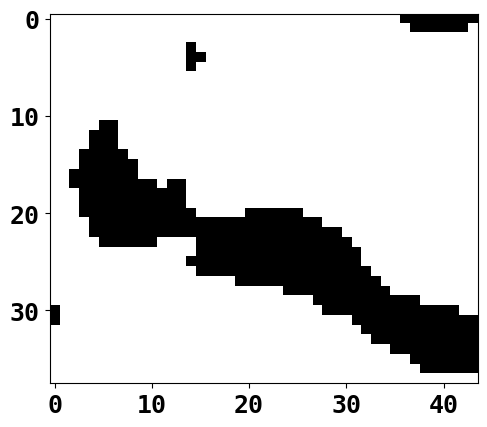

In [93]:
plt.imshow(Rmasked.mask[0],cmap="gray")

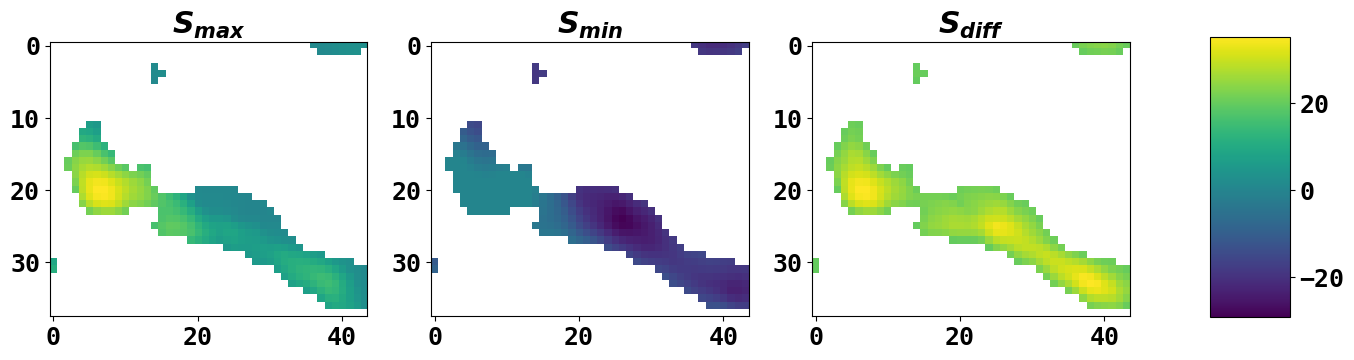

In [95]:
Smasked = np.ma.cumsum(Rmasked, axis =0)
Smasked_max = np.ma.max(Smasked, axis=0)
Smasked_min=np.ma.min(Smasked, axis=0)
Smasked_diff = Smasked_max - Smasked_min
fig, ax = plt.subplots(1,3,figsize=(16,4))
vmin=Smasked_min.min()
vmax=Smasked_max.max()
p=ax[0].imshow(Smasked_max, vmin=vmin, vmax=vmax)
ax[0].set_title('$S_{max}$')
ax[1].imshow(Smasked_min, vmin=vmin, vmax=vmax)
ax[1].set_title("$S_{min}$")
ax[2].imshow(Smasked_diff, vmin=vmin, vmax=vmax)
ax[2].set_title("$S_{diff}$")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
_=fig.colorbar(p,cax=cbar_ax)

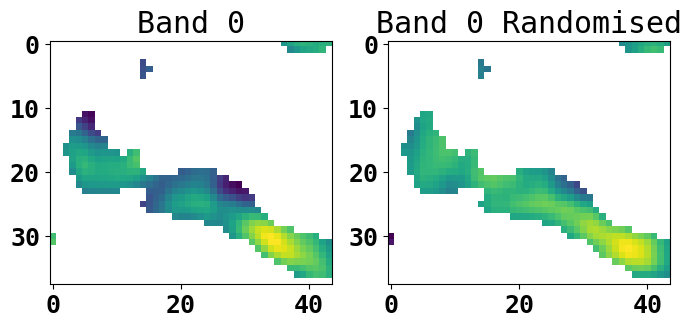

In [96]:
# Bootstrapping over the masked change point candidates

random_index=np.random.permutation(Rmasked.shape[0])
Rrandom=Rmasked[random_index, :, :]

fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(Rmasked[0])
ax[0].set_title("Band 0")
ax[1].imshow(Rrandom[0])
_=ax[1].set_title("Band 0 Randomised")

In [97]:
Smasked_max=np.ma.max(Smasked, axis=0)

In [98]:
n_bootstraps=1000

Sdiff_random_max = np.ma.copy(Smasked_diff)
Sdiff_random_max[~Sdiff_random_max.mask]=0

Sdiff_random_sum = np.ma.copy(Smasked_diff)
Sdiff_random_sum[~Sdiff_random_max.mask]=0

n_Sdiff_gt_Sdiff_random = np.ma.copy(Smasked_diff)
n_Sdiff_gt_Sdiff_random[~n_Sdiff_gt_Sdiff_random.mask]=0
for i in range(n_bootstraps):
    random_index=np.random.permutation(Rmasked.shape[0])
    Rrandom = Rmasked[random_index, :, :]
    Srandom = np.ma.cumsum(Rrandom, axis = 0)
    Srandom_max = np.ma.max(Srandom, axis = 0)
    Srandom_min = np.ma.min(Srandom, axis = 0)
    Sdiff_random = Srandom_max-Srandom_min
    Sdiff_random_sum +=Sdiff_random
    Sdiff_random_max[np.ma.greater(Sdiff_random, Sdiff_random_max)]=\
    Sdiff_random[np.ma.greater(Sdiff_random, Sdiff_random_max)]
    n_Sdiff_gt_Sdiff_random[np.ma.greater(Smasked_diff, Sdiff_random)] += 1
    

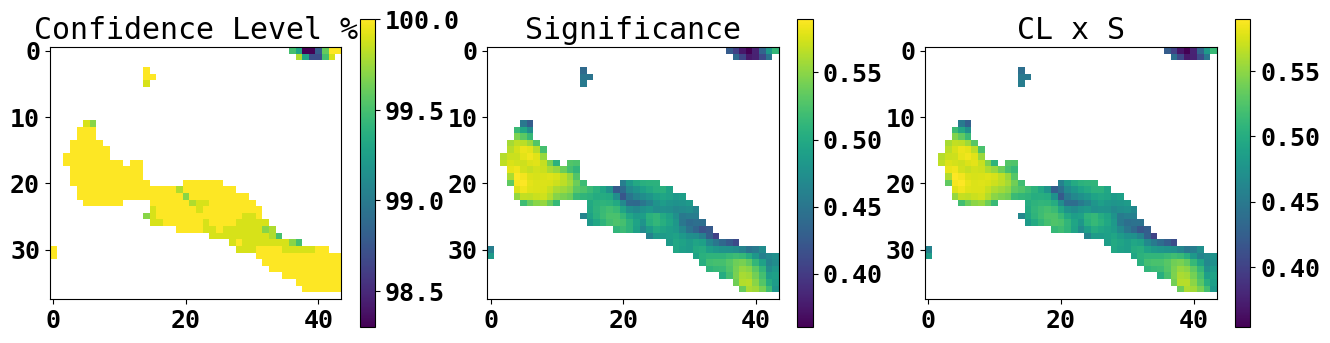

In [100]:
CL = n_Sdiff_gt_Sdiff_random/n_bootstraps
CP_significance = 1.-(Sdiff_random_sum/n_bootstraps)/Sdiff
fig, ax=plt.subplots(1,3,figsize=(16,4))
a=ax[0].imshow(CL*100)
fig.colorbar(a, ax=ax[0])
ax[0].set_title("Confidence Level %")
a=ax[1].imshow(CP_significance)
fig.colorbar(a,ax=ax[1])
ax[1].set_title('Significance')
a=ax[2].imshow(CL*CP_significance)
fig.colorbar(a,ax=ax[2])
_=ax[2].set_title('CL x S')

In [101]:
cp_thres=0.5

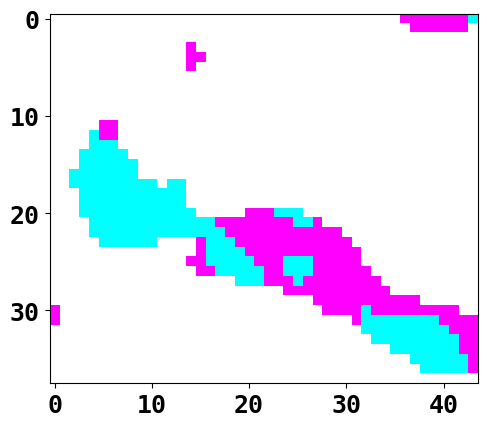

In [102]:
plt.imshow(CL*CP_significance < cp_thres, cmap='cool')

In [104]:
cp_mask = np.ma.mask_or(CL*CP_significance<cp_thres,CL.mask)
cp_mask2 = np.broadcast_to(cp_mask, Smasked.shape)
CPraster = np.ma.array(Smasked.data, mask=cp_mask2)

In [105]:
CP_index = np.ma.argmax(CPraster, axis=0)
change_indices = list(np.unique(CP_index))
change_indices.remove(0)
print(change_indices)

alldates=tindex[tindex>"2015-10-31"]
change_dates=[str(alldates[x+1].date()) for x in change_indices]
print(change_dates)

[2, 27, 28, 29, 32, 33, 34, 35, 36]
['2015-12-23', '2016-11-23', '2016-12-05', '2016-12-17', '2017-01-22', '2017-02-03', '2017-02-15', '2017-02-27', '2017-03-11']


C:\Users\tejashri\AppData\Local\Temp\ipykernel_16768\1973594732.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('magma',ticks[-1])


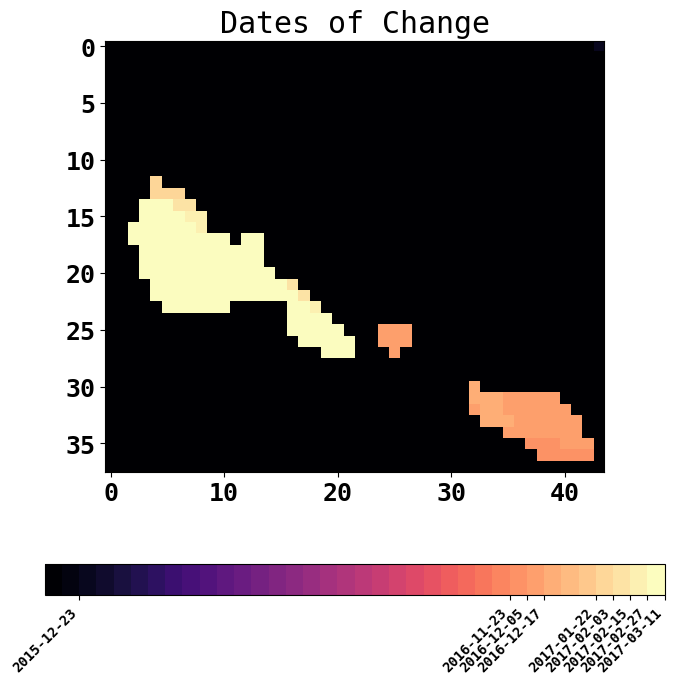

In [111]:
ticks = change_indices
ticklabels = change_dates
cmap=plt.cm.get_cmap('magma',ticks[-1])
# import matplotlib
# cmap=matplotlib.colormaps.get_cmap('magma',ticks[-1])
fig, ax = plt.subplots(figsize=(8,8))
cax = ax.imshow(CP_index, interpolation = 'nearest', cmap=cmap)
ax.set_title("Dates of Change")
cbar = fig.colorbar(cax, ticks=ticks, orientation="horizontal")
_=cbar.ax.set_xticklabels(ticklabels, size=10, rotation=45, ha='right')